In [18]:

import pandas as pd
import numpy as np
import time
import datetime
from tqdm import tqdm
import random

import matplotlib.pyplot as plt
plt.style.use('ggplot')


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import shap
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold, learning_curve, KFold
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
np.set_printoptions(precision=4)

In [3]:
data = pd.read_csv('./flats_prepared.csv').drop('Unnamed: 0', axis = 1)
data.head()

,AD_ID,posted_date,posted_time,shown,price,currency,ptype,l_region,l_2,l_3,...,price/sizeM2,price/net_sizeM2,year_built,year_ren,condition,en_eff,switch,park_spots,balcony,garden
0,6523968,14.03.2021,18:49,57,192000,b'Euro',b'cumulative',b'Savinjska',b'Celje',b'SlavkoSlander',...,2232,1828,2004,0,b'nan',b'None',0,0,0,0
1,6523894,14.03.2021,18:39,29,134500,b'Euro',b'cumulative',b'Osrednjeslovenska',b'LjubljanaCenter',b'Center',...,4803,4637,1908,2020,b'Popolnoma opremljeno',b'EI',1,0,0,0
2,6523589,14.03.2021,18:07,33,29500,b'Euro',b'cumulative',b'Gorenjska',b'Trzic',b'Trzic',...,2681,2681,1961,0,b'nan',b'E',0,0,0,0
3,6523431,14.03.2021,17:47,34,120000,b'Euro',b'cumulative',b'Savinjska',b'SlovenskeKonjice',b'SlovenskeKonjice',...,0,1714,2020,0,b'Neopremljeno',b'A2',0,7,1,0
4,6523190,14.03.2021,17:16,23,180000,b'Euro',b'cumulative',b'Osrednjeslovenska',b'LjubljanaBezigrad',b'Bezigrad',...,3396,0,1988,0,b'nan',b'None',0,0,1,0


# Selecting features and values

In [4]:
ind = (data['sizeM2']<300) & (data['sizeM2']>0) & (data['price']>0)&(data['year_built']>1800)
cols_drop = ['currency', 'AD_ID', 'posted_time', 'posted_date','shown', 'price/sizeM2', 'price/net_sizeM2', 'net_sizeM2', 'ptype']
data[ind].drop(columns = cols_drop).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 811 entries, 0 to 1187
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   price       811 non-null    int64 
 1   l_region    811 non-null    object
 2   l_2         811 non-null    object
 3   l_3         811 non-null    object
 4   sits_in     811 non-null    object
 5   lvl         811 non-null    object
 6   t_lvl       811 non-null    int64 
 7   flat_type   811 non-null    object
 8   sizeM2      811 non-null    int64 
 9   year_built  811 non-null    int64 
 10  year_ren    811 non-null    int64 
 11  condition   811 non-null    object
 12  en_eff      811 non-null    object
 13  switch      811 non-null    int64 
 14  park_spots  811 non-null    int64 
 15  balcony     811 non-null    int64 
 16  garden      811 non-null    int64 
dtypes: int64(9), object(8)
memory usage: 114.0+ KB


# Splitting Train and Test

In [5]:
train, test = train_test_split(data[ind].drop(columns = cols_drop), test_size=0.2, random_state = 42)

In [6]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 298 to 126
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   price       648 non-null    int64 
 1   l_region    648 non-null    object
 2   l_2         648 non-null    object
 3   l_3         648 non-null    object
 4   sits_in     648 non-null    object
 5   lvl         648 non-null    object
 6   t_lvl       648 non-null    int64 
 7   flat_type   648 non-null    object
 8   sizeM2      648 non-null    int64 
 9   year_built  648 non-null    int64 
 10  year_ren    648 non-null    int64 
 11  condition   648 non-null    object
 12  en_eff      648 non-null    object
 13  switch      648 non-null    int64 
 14  park_spots  648 non-null    int64 
 15  balcony     648 non-null    int64 
 16  garden      648 non-null    int64 
dtypes: int64(9), object(8)
memory usage: 91.1+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 163 entries, 309 to 1165
Data co

# Imputing categorical features

In [7]:
def impute_cats(df):
    # Find the columns of object type along with their column index
    object_cols = list(df.select_dtypes(exclude=[np.number]).columns)
    object_cols_ind = []
    for col in object_cols:
        object_cols_ind.append(df.columns.get_loc(col))

    # Encode the categorical columns with numbers
    label_enc = LabelEncoder()
    encoders = {}
    
    
    for i in object_cols_ind:
        df.iloc[:,i] = label_enc.fit_transform(df.iloc[:,i])
        encoders[i] = label_enc
    return df

In [8]:
train_imp = impute_cats(train)
test_imp = impute_cats(test)

# Splitting into X and Y 

In [9]:
X_train = train_imp.drop('price', axis =1)
y_train = np.ravel(np.array(train_imp[['price']]))
X_test = test_imp.drop('price', axis =1)
y_test = np.ravel(np.array(test_imp[['price']]))

In [10]:
X_train.shape
y_train.shape
X_test.shape
y_test.shape

(648, 16)

(648,)

(163, 16)

(163,)

# Defining RMSLE

In [11]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(np.log(y), np.log(y_pred)))

# Fitting the models

## Random Forest

In [22]:
%%time
rf_model = RandomForestRegressor(n_estimators=300,
                                      max_depth=10,
                                      #min_samples_split=5,
                                      #min_samples_leaf=5,
                                      max_features=None,
                                      random_state=42,
                                      oob_score=True
                                     )
kf = KFold(n_splits=5)
y_pred_rf = cross_val_score(rf_model, X_train, y_train, cv=kf, n_jobs=-1)
print(y_pred_rf.mean())
print(y_pred_rf)

0.6703341262018139
[0.7244 0.5269 0.7042 0.7709 0.6253]
Wall time: 1.25 s


In [19]:
%%time
rf_model.fit(X_train, y_train)
y_train_pred_rf = rf_model.predict(X_train)

print('test RMSLE: ' + str(rmsle(y_train, y_train_pred_rf)))

y_test_pred_rf = rf_model.predict(X_test)
print('test RMSLE: ' + str(rmsle(y_test, y_test_pred_rf)))

test RMSLE: 0.45619430240439246
test RMSLE: 1.4556284674857105
Wall time: 984 ms


<BarContainer object of 16 artists>

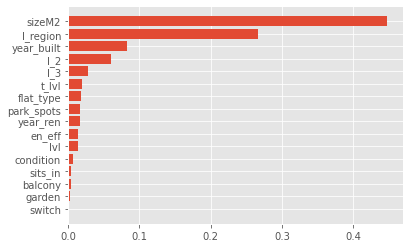

In [14]:
sorted_idx = rf_model.feature_importances_.argsort()
plt.barh(list(X_test.columns[sorted_idx]), rf_model.feature_importances_[sorted_idx])

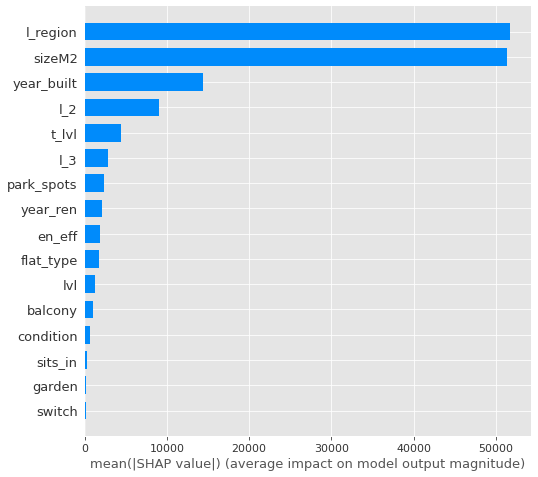

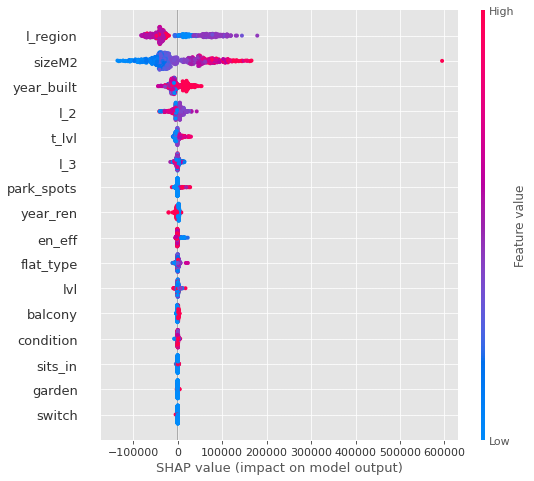

In [15]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

## Gradient boost Regressor GBM

In [24]:
%%time
gboost_model = GradientBoostingRegressor( n_estimators=500, learning_rate=0.01,
                                     max_depth=5, max_features='sqrt',
                                     #min_samples_leaf=15, min_samples_split=10,
                                     loss='ls', random_state =42
                                   )


kf = KFold(n_splits=5)
y_pred_gboost = cross_val_score(gboost_model, X_train, y_train, cv=kf, n_jobs=-1)
print(y_pred_gboost.mean())
print(y_pred_gboost)

0.6779898609209508
[0.6937 0.5218 0.7068 0.805  0.6626]
Wall time: 359 ms


In [25]:
%%time
gboost_model.fit(X_train, y_train)
y_train_pred_gboost = gboost_model.predict(X_train)

print('test RMSLE: ' + str(rmsle(y_train, y_train_pred_gboost)))

y_test_pred_gboost = gboost_model.predict(X_test)
print('test RMSLE: ' + str(rmsle(y_test, y_test_pred_gboost)))

test RMSLE: 0.4730187199893772
test RMSLE: 1.4165352558696267
Wall time: 324 ms


<BarContainer object of 16 artists>

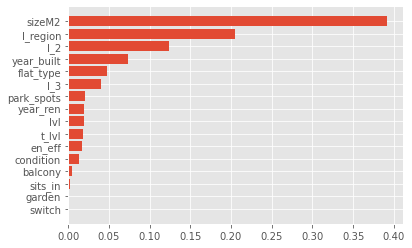

In [94]:
sorted_idx = gboost_model.feature_importances_.argsort()
plt.barh(list(X_test.columns[sorted_idx]), gboost_model.feature_importances_[sorted_idx])

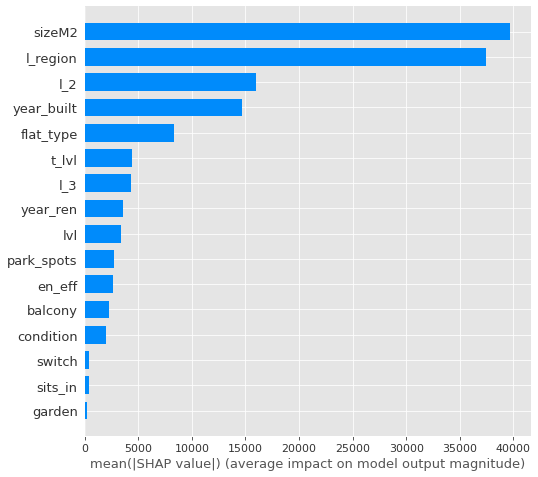

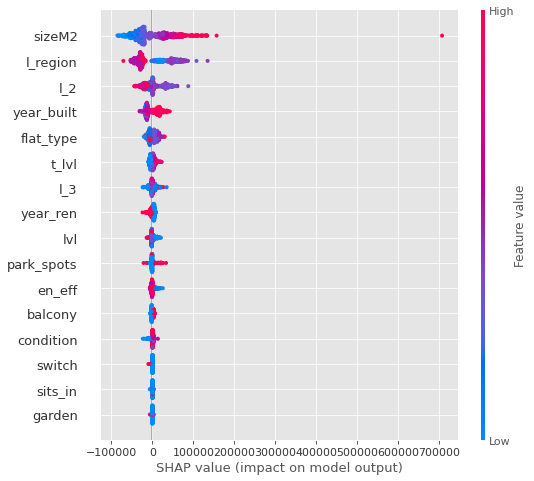

In [96]:
explainer = shap.TreeExplainer(gboost_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

## XGBoost

In [27]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [28]:
%%time
xgboost_model = XGBRegressor(learning_rate=0.01,
                         n_estimators=1000,
                         #max_depth=4, min_child_weight=1,
                         #gamma=0.6, subsample=0.7,
                         #colsample_bytree=0.2,
                         #nthread=-1,
                         scale_pos_weight=1, seed=27,
                         reg_alpha=0.001
                       )

kf = KFold(n_splits=5)
y_pred_xgboost = cross_val_score(xgboost_model, X_train, y_train, cv=kf, n_jobs=-1)
print(y_pred_xgboost.mean())
print(y_pred_xgboost)

0.6815205567077044
[0.7311 0.5802 0.7468 0.7428 0.6067]
Wall time: 3.47 s


In [30]:
%%time
xgboost_model.fit(X_train, y_train)

y_train_pred_xgboost = xgboost_model.predict(X_train)
print('test RMSLE: ' + str(rmsle(y_train, y_train_pred_xgboost)))

y_test_pred_xgboost = xgboost_model.predict(X_test)
print('test RMSLE: ' + str(rmsle(y_test, y_test_pred_xgboost)))



test RMSLE: 0.30421808684275137
test RMSLE: 1.4293059659109457
Wall time: 1.19 s


<BarContainer object of 16 artists>

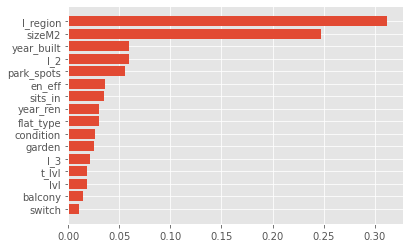

In [88]:
sorted_idx = xgboost_model.feature_importances_.argsort()
plt.barh(list(X_test.columns[sorted_idx]), xgboost_model.feature_importances_[sorted_idx])


<BarContainer object of 16 artists>

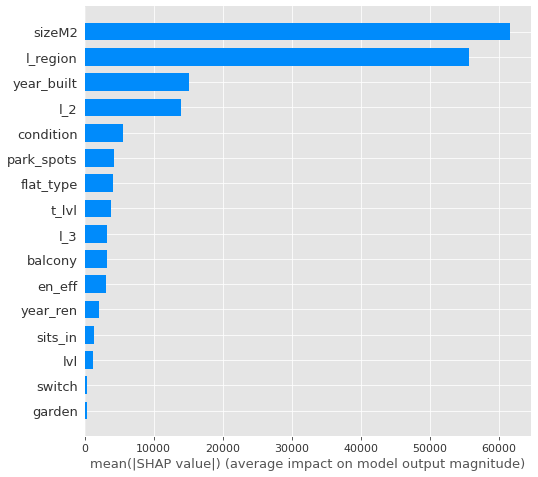

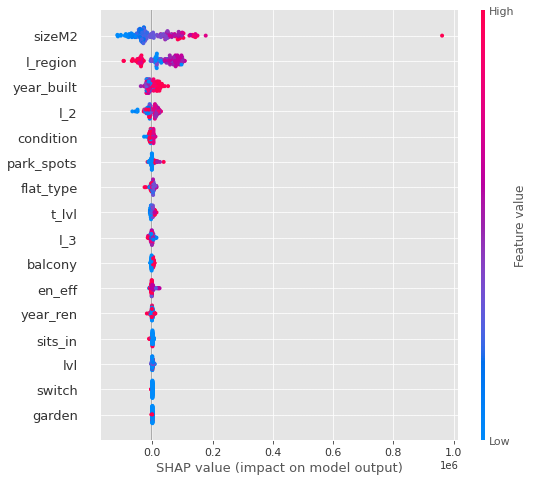

In [82]:

explainer = shap.TreeExplainer(xgboost_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

## LightGBM

In [32]:
%%time
lightgbm_model = LGBMRegressor(objective='regression', 
                                       num_leaves=6,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       verbose=-1,
                                       bagging_fraction=0.80,
                                       bagging_freq=4, 
                                       bagging_seed=6,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                    )

kf = KFold(n_splits=5)
y_pred_lightgbm = cross_val_score(lightgbm_model, X_train, y_train, cv=kf)
print(y_pred_lightgbm.mean())
print(y_pred_lightgbm)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 

In [33]:
%%time
lightgbm_model.fit(X_train, y_train)

y_train_pred_lightgbm = lightgbm_model.predict(X_train)
print('test RMSLE: ' + str(rmsle(y_train, y_train_pred_lightgbm)))

y_test_pred_lightgbm = lightgbm_model.predict(X_test)
print('test RMSLE: ' + str(rmsle(y_test, y_test_pred_lightgbm)))



[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
test RMSLE: 0.5171889294912502
test RMSLE: 1.3986032779163728
Wall time: 1.75 s


<BarContainer object of 16 artists>

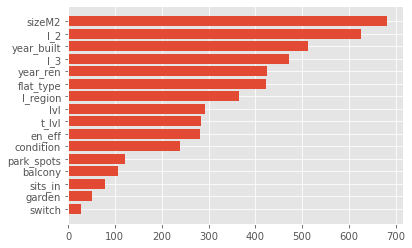

In [113]:
sorted_idx = lightgbm_model.feature_importances_.argsort()
plt.barh(list(X_test.columns[sorted_idx]), lightgbm_model.feature_importances_[sorted_idx])

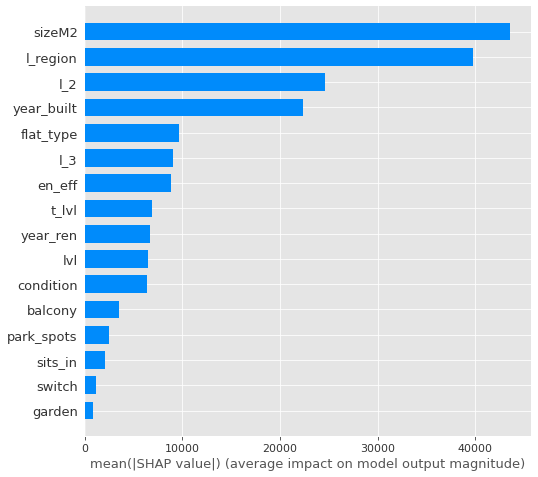

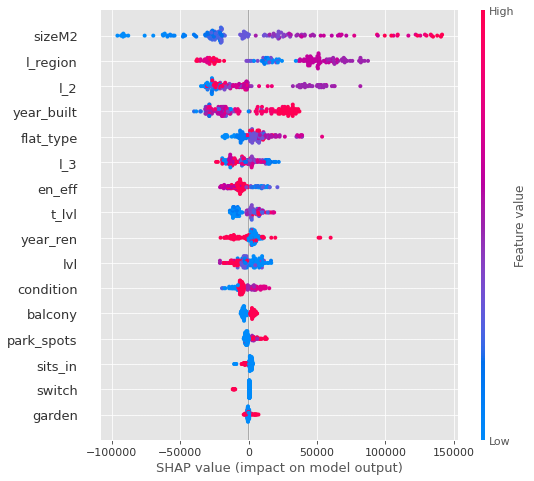

In [110]:
explainer = shap.TreeExplainer(lightgbm_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

# Summary of the models

In [115]:
scores = [['RandomForest',y_pred_rf.mean(),rmsle(y_train, y_train_pred_rf), rmsle(y_test, y_test_pred_rf)],
          ['GBoostReg',y_pred_gboost.mean(),rmsle(y_train, y_train_pred_gboost), rmsle(y_test, y_test_pred_gboost)],
          ['XGBoost',y_pred_xgboost.mean(),rmsle(y_train, y_train_pred_xgboost), rmsle(y_test, y_test_pred_xgboost)],
          ['LightGBM',y_pred_lightgbm.mean(),rmsle(y_train, y_train_pred_lightgbm), rmsle(y_test, y_test_pred_lightgbm)]        
         ]

In [116]:
scores_df = pd.DataFrame(scores, columns = ['Model_Name', 'y_pred', 'RMSLE_train', 'RMSLE_test'])
scores_df

,Model_Name,y_pred,RMSLE_train,RMSLE_test
0,RandomForest,0.670334,0.456194,1.455628
1,GBoostReg,0.677990,0.473019,1.416535
2,XGBoost,0.681521,0.304218,1.429306
3,LightGBM,0.675601,0.606783,1.409162
